## Settings


In [5]:
import matplotlib.pyplot as plt
import os
import numpy as np

import os
from pathlib import Path
import pickle
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SequentialSampler
import torch

import numpy as np

from tqdm import tqdm
from model import FeatureExtractor
from utils import read_index, write_index, create_index

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [7]:
data_path = Path("data")

os.listdir(data_path)

['asia_park_in_da_nang',
 'bai_dinh_pagoda',
 'ban_gioc_waterfall',
 'ben_thanh_market',
 'bich_dong_pagoda',
 'christ_of_vung_tau',
 'clay_pagoda_in_soc_trang',
 'cu_chi_tunnels',
 'dalat_railway_station',
 'datanla_waterfall',
 'dragon_bridge_in_da_nang',
 'fansipan_mountain',
 'golden_bridge_in_da_nang',
 'ha_long_bay',
 'hoan_kiem_lake',
 'hoa_lu_ancient_capital',
 'hoi_an_ancient_town',
 'ho_chi_minh_mausoleum',
 'japanese_covered_bridge_in_quang_nam',
 'khai_dinh_tomb',
 'lam_vien_square',
 'landmark_81_in_ho_chi_minh_city',
 'ly_son_island',
 'mui_ne',
 'my_son_sanctuary',
 'nha_rong_harbor',
 'ninh_kieu_market',
 'one-pillar_pagoda',
 'paradise_cave_in_quang_binh',
 'phat_diem_cathedral',
 'po_klong_garai_tower_in_ninh_thuan',
 'pu_luong_rice_terraces',
 'reunification_palace_in_ho_chi_minh_city',
 'saigon_notre_dame_cathedral',
 'sapa_heaven_gate',
 'sapa_stone_church',
 'suoi_tien_theme_park',
 'sơn_đoòng_cave_in_quang_binh',
 'tam_chuc_pagoda',
 'thao_cam_vien_zoo',
 'the_im

In [8]:
def load_dict(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)

## Dataset


In [9]:
not_ground_truth = load_dict(file_path="annotation/anti_gnd.pkl")

query = load_dict(file_path="annotation/query.pkl")

In [10]:
landmarks = list(query.keys())

len(landmarks)

47

In [11]:
imlist = dict()

for key in landmarks:
    imlist[key] = []
    for filename in os.listdir(os.path.join(data_path, key)):
        file_idx = int(filename.split(".")[0])
        # select only jpg files not in query set
        if filename.endswith(".jpg") and file_idx not in query[key]:
            imlist[key].append(filename)

In [12]:
ground_truth = dict()

for key in landmarks:
    ground_truth[key] = []
    for filename in os.listdir(os.path.join(data_path, key)):
        file_idx = int(filename.split(".")[0])
        # select only jpg files in ground truth set
        if (
            filename.endswith(".jpg")
            and file_idx not in not_ground_truth[key]
            and file_idx not in query[key]
        ):
            ground_truth[key].append(filename)

In [13]:
query_loc = []

for landmark in query.keys():
    for filename in query[landmark]:
        image_path = os.path.join(data_path, landmark, f"{filename}.jpg")
        query_loc.append(image_path)


def path_to_landmark(path):
    return path.split("\\")[1]  # windows path


def get_query(query_loc, query_idx):
    img_path = query_loc[query_idx]
    img = Image.open(img_path)
    landmark = path_to_landmark(img_path)
    return img, landmark

In [94]:
def extract_correct_ans(ans_list, query_landmark):
    correct_ans = []
    gnd_list = ground_truth[query_landmark]
    for ans in ans_list:
        _, ans_landmark, filename = ans.split("\\")

        if ans_landmark == query_landmark and filename in gnd_list:
            correct_ans.append(ans)
    return correct_ans

In [15]:
class Vietnam47AttrDataset(Dataset):
    def __init__(self, imlist, transform=None):
        self.imlist = imlist
        self.landmarks = list(imlist.keys())
        self.lengths = [len(value) for value in imlist.values()]
        self.image_loc = self._load_data()
        self.transform = transform

    def __len__(self):
        return sum(self.lengths)

    def _get_filepath(self, idx):
        return self.image_loc[idx]

    def __getitem__(self, index):
        img_path = self._get_filepath(index)
        img = Image.open(img_path)
        img = img.convert("RGB")

        if self.transform:
            img = self.transform(img)
        return img, img_path

    def _load_data(self):
        images_loc = []
        for landmark in self.landmarks:
            for filename in self.imlist[landmark]:
                image_path = os.path.join(data_path, landmark, filename)
                images_loc.append(image_path)
        return images_loc

In [16]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [17]:
ds = Vietnam47AttrDataset(imlist, transform=transform)
sampler = SequentialSampler(ds)
dl = DataLoader(ds, batch_size=64, sampler=sampler)


len(ds), len(dl)

(9102, 143)

In [18]:
batch, paths = next(iter(dl))

batch.shape, len(paths)

(torch.Size([64, 3, 224, 224]), 64)

# Model


In [19]:
extractor = FeatureExtractor().to(device)

In [20]:
index = create_index(extractor.feature_size, metrics="IP")

In [21]:
# with tqdm(total=len(dl), desc="Extracting features") as pbar:
#     for batch, _ in dl:
#         batch = batch.to(device)
#         features = extractor(batch)
#         index.add(features)
#         pbar.update(1)

# write_index(index, "index/Vietnam47Attr.resnet50_IP.bin")

In [22]:
index = read_index("index/Vietnam47Attr.resnet50_IP.bin")

print(f"Number of vectors in index: {index.ntotal}")

Number of vectors in index: 9102


# Retrieval


In [130]:
def retrieve(query_img, k, index=index):
    img = transform(query_img)
    img = img.unsqueeze(0).to(device)

    feat = extractor(img)
    distance, indices = index.search(feat, k)

    return indices[0].tolist(), distance[0].tolist()

In [131]:
def plot_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [138]:
view_ds = Vietnam47AttrDataset(imlist, transform=None)

(<matplotlib.image.AxesImage at 0x212d556ef50>, 'thien_mu_pagoda_in_hue')

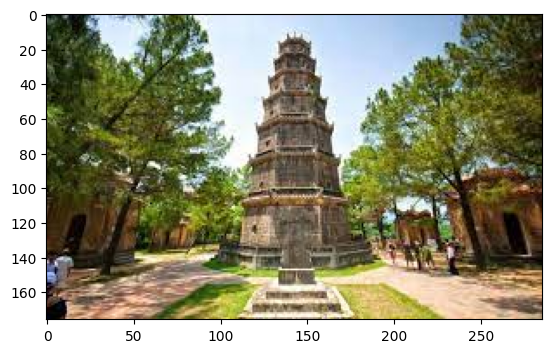

In [147]:
rand_idx = np.random.randint(0, len(query_loc))
img, lm = get_query(query_loc, rand_idx)

plt.imshow(img), lm

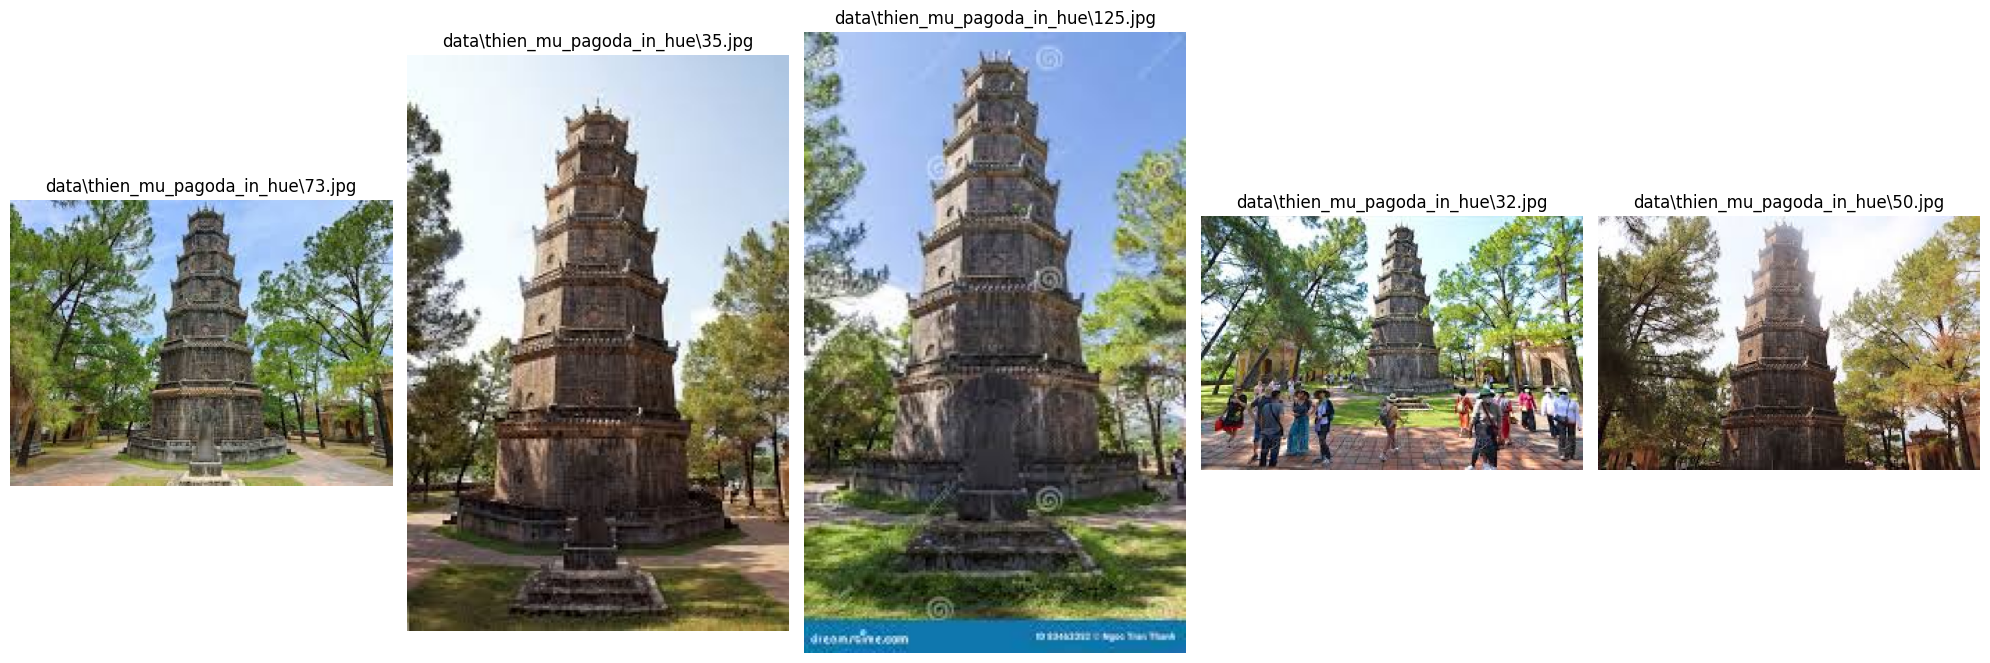

In [148]:
idx, dst = retrieve(img, 5)

images = []
titles = []

cols = 5
rows = 1

for i in idx:
    images.append(view_ds[i][0])
    titles.append(view_ds[i][1])

plot_images(images, titles, rows, cols)

# Evaluation


## Recall

In [100]:
answer_list = []
qlandmark_list = []

for i in tqdm(range(len(query_loc))):
    img, query_landmark = get_query(query_loc, i)
    gnd_size = len(ground_truth[query_landmark])
    idx, dst = retrieve(img, gnd_size)

    ans = [ds._get_filepath(i) for i in idx]
    answer_list.append(ans)
    qlandmark_list.append(query_landmark)

100%|██████████| 235/235 [00:03<00:00, 70.65it/s]


In [103]:
def compute_recall(ans, query_landmark):
    correct_ans = extract_correct_ans(ans, query_landmark)
    return len(correct_ans) / len(ground_truth[query_landmark])

In [150]:
recall_scores = []

for ans, landmark in zip(answer_list, qlandmark_list):
    if len(ans) > 0:
        recall_scores.append(compute_recall(ans, landmark))

recall_scores = np.array(recall_scores)
print(f"R-Precision: {recall_scores.mean():.2f}")

R-Precision: 0.36


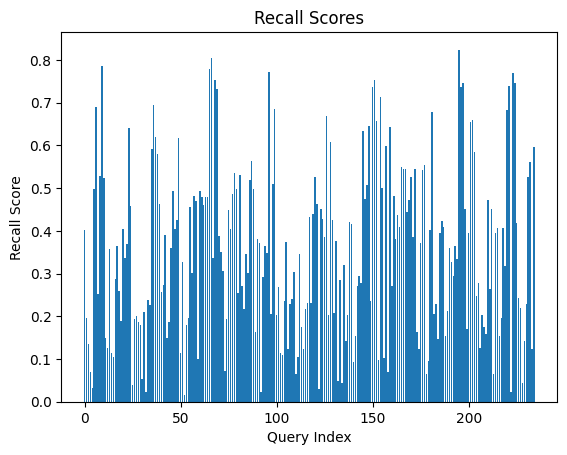

In [151]:
import matplotlib.pyplot as plt

plt.bar(range(len(recall_scores)), recall_scores)
plt.xlabel("Query Index")
plt.ylabel("Recall Score")
plt.title("Recall Scores")
plt.show()

# mAP

In [122]:
def ap(ans, query_landmark):
    precision_scores = []
    cor_cases = 0
    for idx, a in enumerate(ans):
        _, ans_landmark, filename = a.split("\\")

        if ans_landmark == query_landmark and filename in ground_truth[query_landmark]:
            cor_cases += 1
            precision_scores.append(cor_cases / (idx + 1))

    return sum(precision_scores) / len(ans)


def mapk(ans_list, query_landmark_list, k):
    ap_scores = []
    for ans, landmark in zip(ans_list, query_landmark_list):
        if len(ans) > 0:
            ap_scores.append(ap(ans[:k], landmark))
    return sum(ap_scores) / len(ap_scores)

In [152]:
k_list = [1, 5, 10, 20]
mapk_scores = [mapk(answer_list, qlandmark_list, k) for k in k_list]

In [162]:
import pandas as pd

data = {"Score": mapk_scores}

df = pd.DataFrame(data, index=[f"mAP@{k}" for k in k_list])

df.round(3)

,Score
mAP@1,0.889
mAP@5,0.791
mAP@10,0.716
mAP@20,0.629
